# Lab 3: Contextual Bandit-Based News Article Recommendation System

**Course:** Reinforcement Learning Fundamentals  
**Student Name:** Abhijeet 
**Roll Number:** U20230101  
**GitHub Branch:** abhijeet_u20230101

---

## Objective
Implement a News Recommendation System using Contextual Multi-Armed Bandits (CMAB) to recommend news articles based on user categories.

## Imports and Setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
import xgboost as xgb

from rlcmab_sampler import sampler

# Configure advanced plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# SET YOUR ROLL NUMBER HERE

ROLL_NUMBER = "U20230101"  # Update this with your actual roll numberprint(f"Roll Number: {ROLL_NUMBER}")

## Load Datasets

In [17]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("Datasets loaded successfully!")
print(f"\nNews articles shape: {news_df.shape}")
print(f"Train users shape: {train_users.shape}")
print(f"Test users shape: {test_users.shape}")

print("\nNews categories:", news_df['category'].unique())
print("\nUser labels:", train_users['label'].unique())

os.makedirs('cache', exist_ok=True)
# Create cache directory

Datasets loaded successfully!

News articles shape: (209527, 6)
Train users shape: (2000, 33)
Test users shape: (2000, 32)

News categories: ['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']

User labels: ['user_3' 'user_2' 'user_1']


### Exploratory Data Analysis

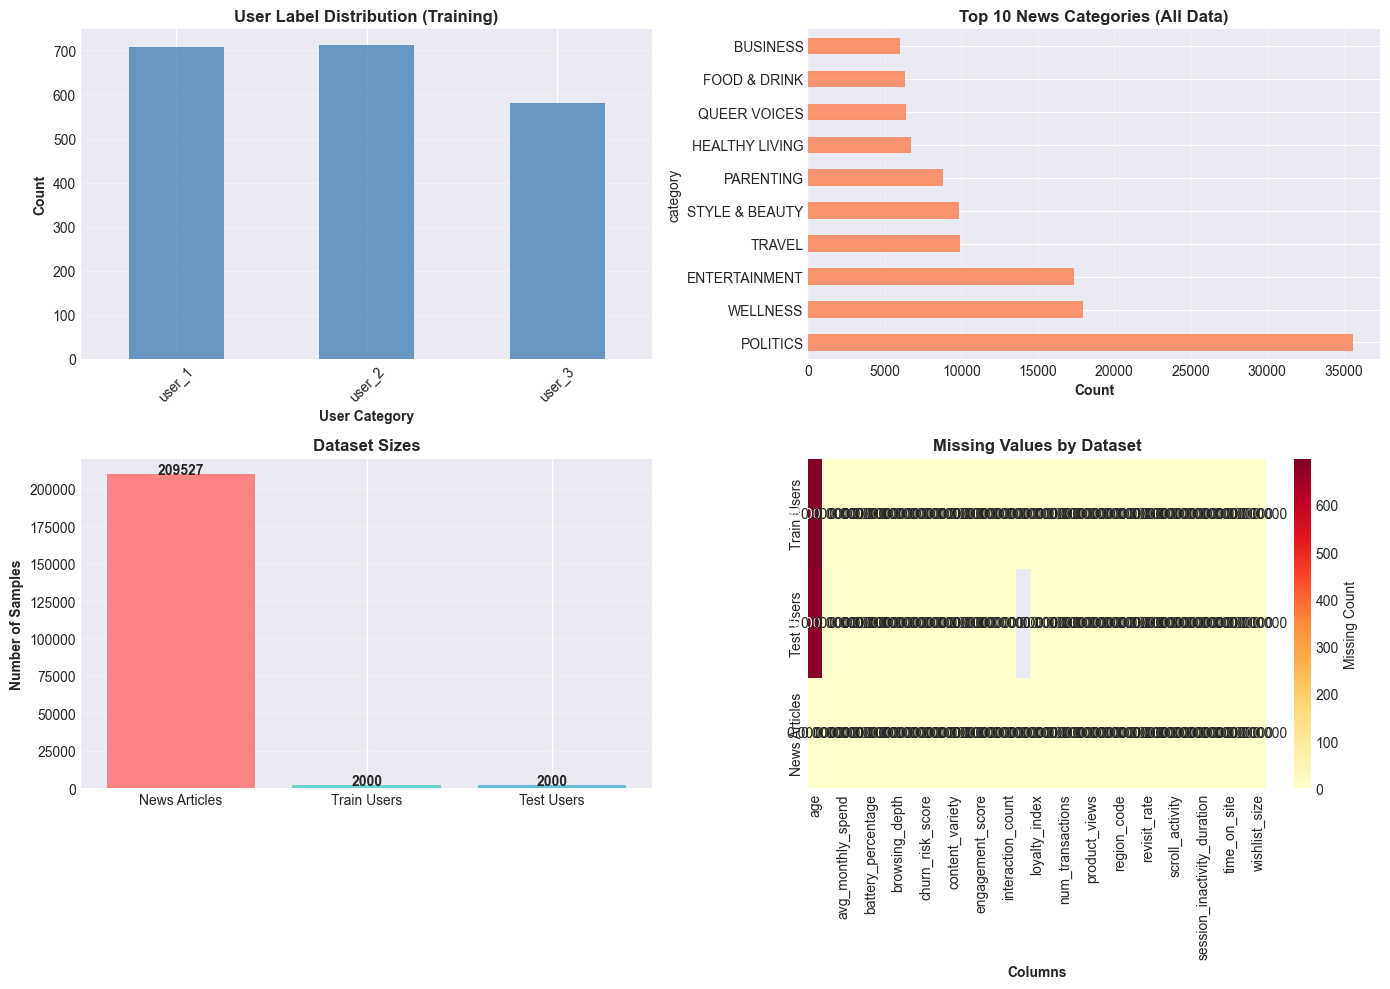


DATA SUMMARY (Initial)
Total news articles: 209527
Training users: 2000
Test users: 2000
Total missing values in train_users: 698
Total missing values in test_users: 679


In [18]:
# Basic Data Exploration (before filtering)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. User label distribution
train_users['label'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue', alpha=0.8)
axes[0, 0].set_title('User Label Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('User Category', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. News category distribution (top 10)
news_df['category'].value_counts().head(10).plot(kind='barh', ax=axes[0, 1], color='coral', alpha=0.8)
axes[0, 1].set_title('Top 10 News Categories (All Data)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Count', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Dataset shapes comparison
datasets = ['News Articles', 'Train Users', 'Test Users']
shapes = [news_df.shape[0], train_users.shape[0], test_users.shape[0]]
axes[1, 0].bar(datasets, shapes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1, 0].set_title('Dataset Sizes', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Samples', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(shapes):
    axes[1, 0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# 4. Missing values heatmap
missing_data = pd.DataFrame({
    'Train Users': train_users.isnull().sum(),
    'Test Users': test_users.isnull().sum(),
    'News Articles': news_df.isnull().sum().reindex(train_users.columns, fill_value=0)
})
sns.heatmap(missing_data.T, annot=True, fmt='f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Missing Count'})
axes[1, 1].set_title('Missing Values by Dataset', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Columns', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("DATA SUMMARY (Initial)")
print("="*70)
print(f"Total news articles: {len(news_df)}")
print(f"Training users: {len(train_users)}")
print(f"Test users: {len(test_users)}")
print(f"Total missing values in train_users: {train_users.isnull().sum().sum()}")
print(f"Total missing values in test_users: {test_users.isnull().sum().sum()}")
print("="*70)

## 5.1 Data Pre-processing

In this section we:
- Handle missing values  
- Filter news articles for relevant categories (Entertainment, Education, Tech, Crime)  
- Encode categorical features  
- Prepare data for user classification

Articles after filtering: (24042, 6)
Categories: ['TECH' 'ENTERTAINMENT' 'EDUCATION' 'CRIME']

Filtered Category Distribution:
  • ENTERTAINMENT: 17362 articles
  • EDUCATION: 1014 articles
  • TECH: 2104 articles
  • CRIME: 3562 articles


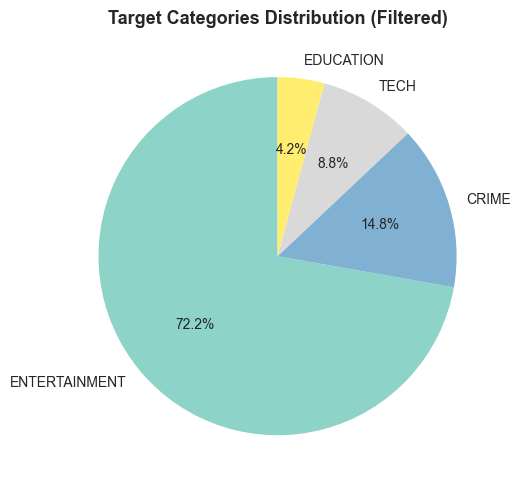


PREPROCESSING USER DATA

✓ Preprocessing completed successfully!

Unique User Labels: ['User1', 'User2', 'User3']

Missing Values Check:
  • Training data: 0 missing values
  • Test data: 0 missing values

✓ All missing values handled successfully!


In [19]:
# Filter Articles for relevant categories (per assignment requirement)
target_categories = ['ENTERTAINMENT', 'EDUCATION', 'TECH', 'CRIME']
news_df_filtered = news_df[news_df['category'].isin(target_categories)].copy()
news_df_filtered.reset_index(drop=True, inplace=True)

print(f"Articles after filtering: {news_df_filtered.shape}")
print(f"Categories: {news_df_filtered['category'].unique()}")

# Display filtered category distribution
print(f"\nFiltered Category Distribution:")
for cat in target_categories:
    count = (news_df_filtered['category'] == cat).sum()
    print(f"  • {cat}: {count} articles")

# Visualize filtered categories
fig, ax = plt.subplots(figsize=(10, 5))
target_cat_counts = news_df_filtered['category'].value_counts()
ax.pie(target_cat_counts.values, labels=target_cat_counts.index, autopct='%1.1f%%', 
       colors=plt.cm.Set3(np.linspace(0, 1, len(target_cat_counts))), startangle=90)
ax.set_title('Target Categories Distribution (Filtered)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Enhanced User Preprocessing with Comprehensive Missing Value Handling
def preprocess_users(df, is_training=True, fill_values=None):
    """
    Advanced preprocessing with robust missing value handling
    
    Args:
        df: Input dataframe
        is_training: Whether this is training data (compute statistics)
        fill_values: Dictionary of fill values from training (for test data)
    
    Returns:
        df_clean: Cleaned dataframe
        fill_values: Dictionary of fill values used
    """
    df_clean = df.copy()
    
    # Normalize Labels (user_1 -> User1, user_2 -> User2, etc.)
    if 'label' in df_clean.columns:
        df_clean['label'] = df_clean['label'].str.replace('user_', 'User', regex=False).str.capitalize()
    
    # Separate numeric and categorical columns
    exclude_cols = ['user_id', 'label']
    numeric_cols = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in exclude_cols]
    categorical_cols = [col for col in df_clean.select_dtypes(include=['object']).columns 
                       if col not in exclude_cols]
    
    # Initialize fill_values if training
    if is_training:
        fill_values = {
            'numeric_means': {},
            'numeric_medians': {},
            'categorical_modes': {}
        }
        
        # Compute statistics for numeric columns
        for col in numeric_cols:
            fill_values['numeric_means'][col] = df_clean[col].mean()
            fill_values['numeric_medians'][col] = df_clean[col].median()
        
        # Compute modes for categorical columns
        for col in categorical_cols:
            mode_val = df_clean[col].mode()
            fill_values['categorical_modes'][col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    # Handle missing values in numeric columns (use mean imputation)
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            fill_val = fill_values['numeric_means'].get(col, df_clean[col].mean())
            if pd.isna(fill_val):  # If all values are NaN
                fill_val = 0
            df_clean[col].fillna(fill_val, inplace=True)
    
    # Handle missing values in categorical columns (use mode imputation)
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            fill_val = fill_values['categorical_modes'].get(col, 'Unknown')
            df_clean[col].fillna(fill_val, inplace=True)
    
    # Final check: fill any remaining NaN with 0 for numeric, 'Unknown' for categorical
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(0, inplace=True)
    
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna('Unknown', inplace=True)
    
    return df_clean, fill_values

# Apply preprocessing
print(f"\n{'='*70}")
print("PREPROCESSING USER DATA")
print(f"{'='*70}")

train_users_clean, fill_values = preprocess_users(train_users, is_training=True)
test_users_clean, _ = preprocess_users(test_users, is_training=False, fill_values=fill_values)

print(f"\n✓ Preprocessing completed successfully!")
print(f"\nUnique User Labels: {sorted(train_users_clean['label'].unique())}")
print(f"\nMissing Values Check:")
print(f"  • Training data: {train_users_clean.isnull().sum().sum()} missing values")
print(f"  • Test data: {test_users_clean.isnull().sum().sum()} missing values")

# Verify no missing values remain
assert train_users_clean.isnull().sum().sum() == 0, "Training data still has missing values!"
assert test_users_clean.isnull().sum().sum() == 0, "Test data still has missing values!"
print(f"\n✓ All missing values handled successfully!")
print(f"{'='*70}")

## 5.2 User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`), which serves as the **context** for the contextual bandit.

**Advanced Approach:**
- **Model**: XGBoost with GridSearchCV hyperparameter tuning
- **Feature Engineering**: StandardScaler normalization + Polynomial feature expansion (degree=2)
- **Validation**: Stratified K-Fold cross-validation (5 splits)
- **Metrics**: Accuracy, F1-Score, Cohen's Kappa, ROC-AUC curves, and confusion matrix
- **Visualization**: ROC curves, learning curves, feature importance heatmaps, precision-recall analysis


FEATURE ENGINEERING & MODEL TRAINING

Encoding 2 categorical features...
Applying feature scaling (StandardScaler)...
Expanding feature space with polynomial features (degree=2)...
Original features: 31 → Polynomial features: 527

Training set: 1600 samples
Validation set: 400 samples

HYPERPARAMETER TUNING WITH GRIDSEARCHCV (CACHED)

✓ Loading cached model...
✓ Model loaded from cache!

CLASSIFICATION RESULTS (VALIDATION SET)

Accuracy: 0.9100
F1-Score (weighted): 0.9104
Cohen's Kappa: 0.8651

Detailed Classification Report:
              precision    recall  f1-score   support

       User1       0.89      0.87      0.88       142
       User2       1.00      0.89      0.94       142
       User3       0.85      0.99      0.91       116

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400




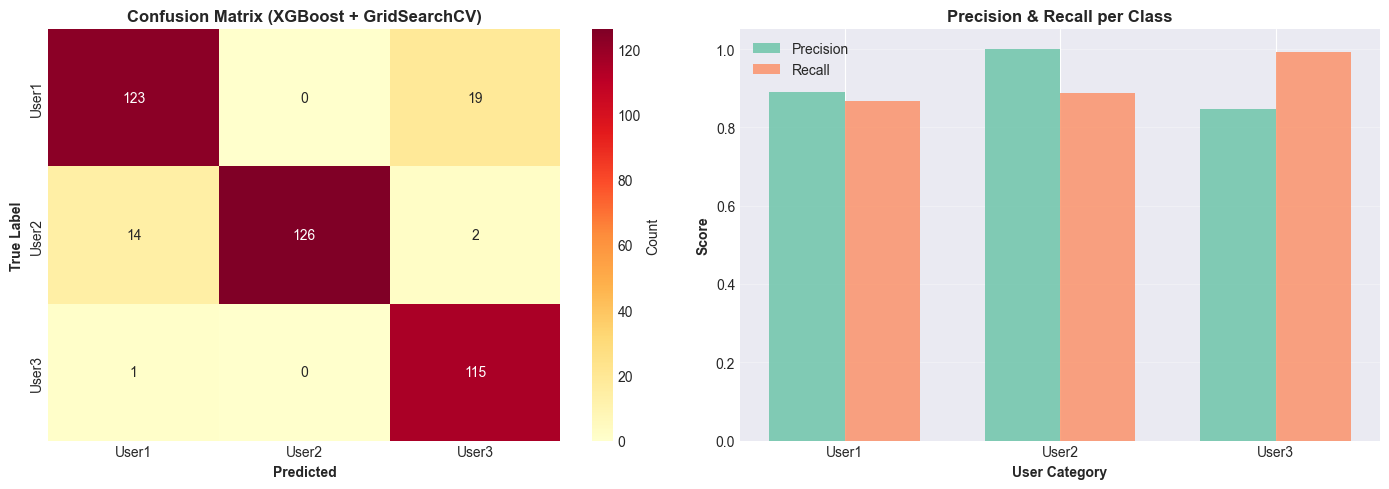

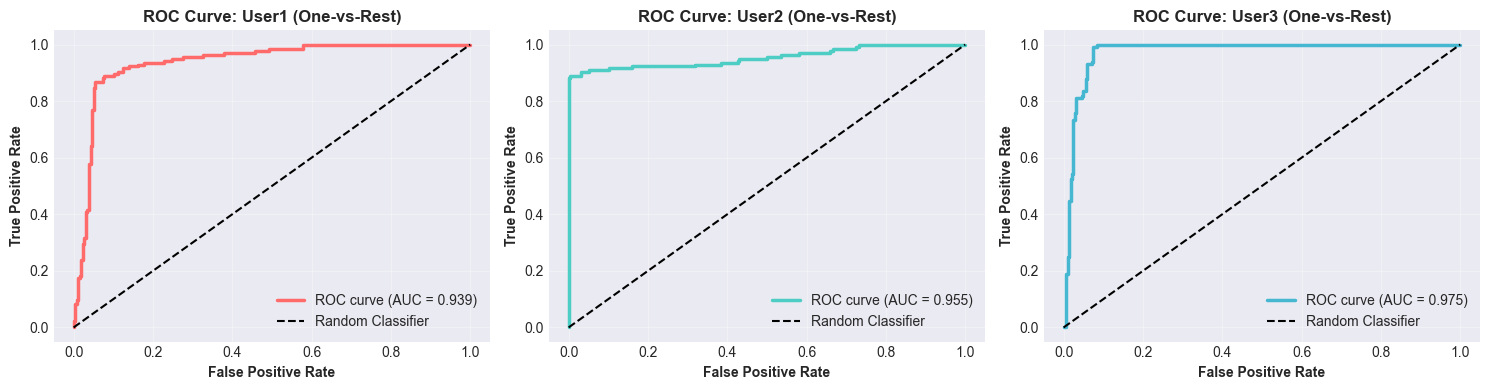


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
   1. session_duration                         → 0.0494
   2. region_code                              → 0.0284
   3. engagement_score preferred_price_range   → 0.0189
   4. content_variety engagement_score         → 0.0187
   5. content_variety^2                        → 0.0110
   6. age^2                                    → 0.0110
   7. session_duration^2                       → 0.0092
   8. scroll_activity time_on_site             → 0.0088
   9. scroll_activity                          → 0.0087
  10. scroll_activity preferred_price_range    → 0.0068
  11. purchase_amount content_variety          → 0.0067
  12. session_duration time_on_site            → 0.0061
  13. time_on_site                             → 0.0058
  14. browsing_depth                           → 0.0057
  15. engagement_score scroll_activity         → 0.0055

Generating learning curves (this may take a moment)...


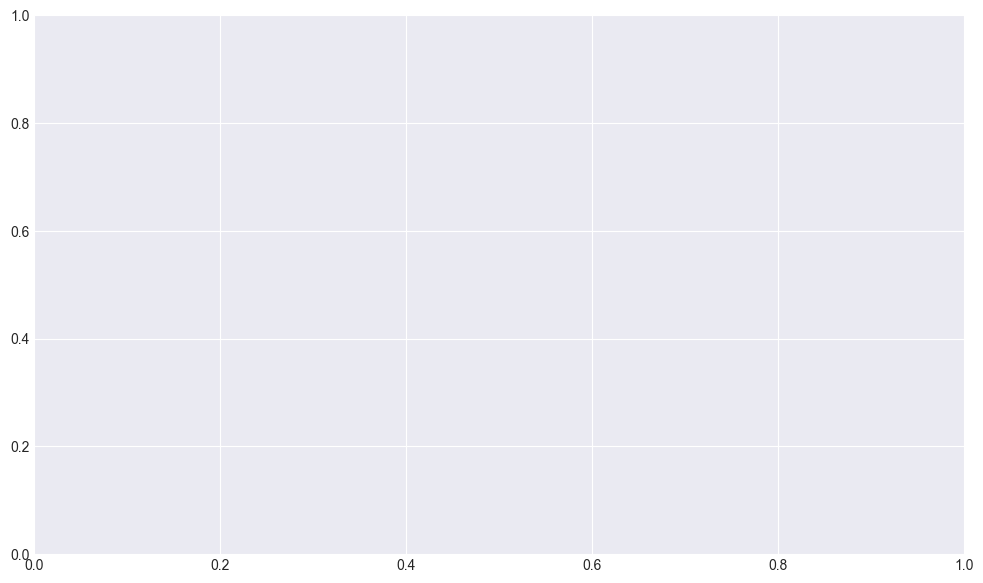

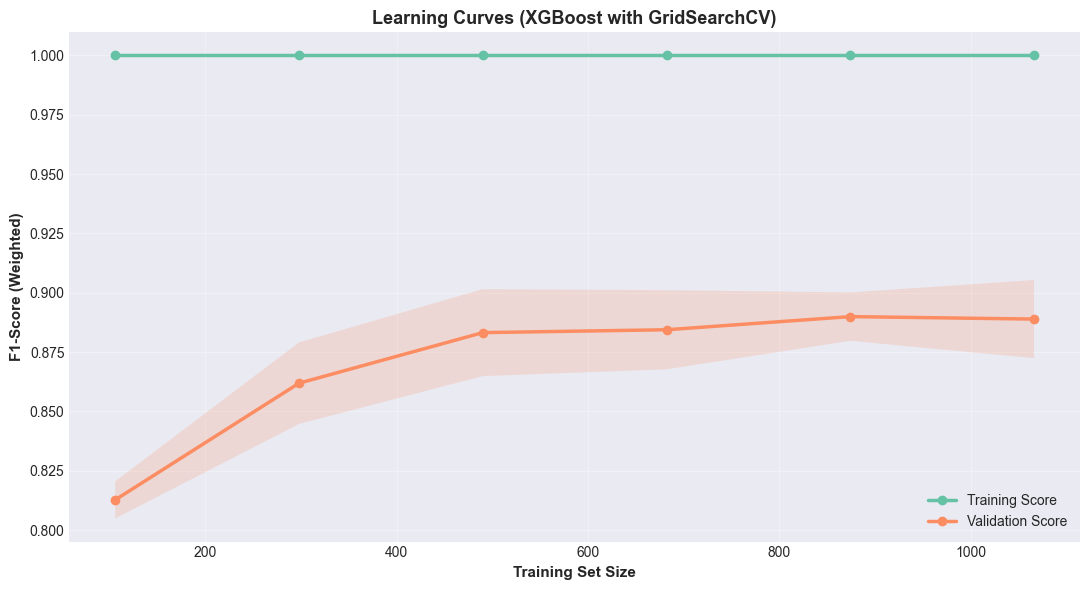


Context Mapping: {'User1': 0, 'User2': 1, 'User3': 2}


In [25]:
# Prepare Feature Matrix and Target
drop_cols = ['user_id', 'label']
X = train_users_clean.drop(columns=[col for col in drop_cols if col in train_users_clean.columns])
y = train_users_clean['label']

# Encode target labels
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)  # User1->0, User2->1, User3->2

print(f"\n{'='*70}")
print("FEATURE ENGINEERING & MODEL TRAINING")
print(f"{'='*70}")

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
numeric_cols_original = X.select_dtypes(include=[np.number]).columns.tolist()

X_encoded = X.copy()
X_test_final = test_users_clean.drop(columns=['user_id', 'label'], errors='ignore').copy()

if len(categorical_cols) > 0:
    print(f"\nEncoding {len(categorical_cols)} categorical features...")
    for col in categorical_cols:
        le = LabelEncoder()
        all_values = pd.concat([X[col], X_test_final[col]], axis=0).astype(str)
        le.fit(all_values)
        X_encoded[col] = le.transform(X[col].astype(str))
        X_test_final[col] = le.transform(X_test_final[col].astype(str))
        encoders[col] = le

# Feature Scaling
print(f"Applying feature scaling (StandardScaler)...")
scaler = StandardScaler()
numeric_features = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])
X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])

# Polynomial Feature Expansion (enhance feature space)
print(f"Expanding feature space with polynomial features (degree=2)...")
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_encoded)
X_test_poly = poly.transform(X_test_final)
feature_names = poly.get_feature_names_out(X_encoded.columns)

print(f"Original features: {X_encoded.shape[1]} → Polynomial features: {X_poly.shape[1]}")

# Split Training Data (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_poly, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# XGBoost Model with Cached GridSearchCV
print(f"\n{'='*70}")
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV (CACHED)")
print(f"{'='*70}")

cache_file = 'cache/xgb_model_poly.pkl'
if os.path.exists(cache_file):
    print("\n✓ Loading cached model...")
    user_classifier = joblib.load(cache_file)
    print("✓ Model loaded from cache!")
else:
    print("\nNo cache found. Training new model...")
    # Reduced parameter grid for faster training
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    
    print(f"Parameter grid: {param_grid}")
    print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
    
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        tree_method='hist',
        device='cpu',
        verbosity=0,
        early_stopping_rounds=10
    )
    
    # GridSearchCV with reduced folds
    print(f"\nStarting GridSearchCV (3-fold CV)...")
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (F1): {grid_search.best_score_:.4f}")
    
    # Use best model
    user_classifier = grid_search.best_estimator_
    
    # Cache the model
    joblib.dump(user_classifier, cache_file)
    print(f"\n✓ Model cached at {cache_file}")

# Validation predictions
y_pred = user_classifier.predict(X_val)
y_pred_proba = user_classifier.predict_proba(X_val)
val_accuracy = accuracy_score(y_val, y_pred)

print(f"\n{'='*70}")
print("CLASSIFICATION RESULTS (VALIDATION SET)")
print(f"{'='*70}")
print(f"\nAccuracy: {val_accuracy:.4f}")
print(f"F1-Score (weighted): {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=le_target.classes_))

print(f"\n{'='*70}")

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_title('Confusion Matrix (XGBoost + GridSearchCV)', fontweight='bold', fontsize=12)

# Per-class metrics
precisions = precision_score(y_val, y_pred, average=None)
recalls = recall_score(y_val, y_pred, average=None)

x_pos = np.arange(len(le_target.classes_))
width = 0.35
axes[1].bar(x_pos - width/2, precisions, width, label='Precision', alpha=0.8)
axes[1].bar(x_pos + width/2, recalls, width, label='Recall', alpha=0.8)
axes[1].set_xlabel('User Category', fontweight='bold')
axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Precision & Recall per Class', fontweight='bold', fontsize=12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(le_target.classes_)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ROC Curve Analysis (One-vs-Rest)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (class_label, color) in enumerate(zip(le_target.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_val == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[i].plot(fpr, tpr, color=color, lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
    axes[i].set_xlabel('False Positive Rate', fontweight='bold')
    axes[i].set_ylabel('True Positive Rate', fontweight='bold')
    axes[i].set_title(f'ROC Curve: {class_label} (One-vs-Rest)', fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}")

importance = user_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
for idx, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"  {idx:2d}. {row['Feature']:40s} → {row['Importance']:.4f}")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(12, 7))
top_n = 20

# Learning Curve (cached)
learning_curve_cache = 'cache/learning_curve_data.pkl'

if os.path.exists(learning_curve_cache):
    print("\n✓ Loading cached learning curve data...")
    train_sizes, train_scores, val_scores = joblib.load(learning_curve_cache)
else:
    print("\nGenerating learning curves (this may take a moment)...")
    # Create a fresh estimator without early stopping for learning curves
    lc_params = user_classifier.get_params()
    lc_params['early_stopping_rounds'] = None
    lc_estimator = xgb.XGBClassifier(**lc_params)
    
    train_sizes, train_scores, val_scores = learning_curve(
        lc_estimator,
        X_train, y_train,
        cv=3,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        scoring='f1_weighted'
    )
    joblib.dump((train_sizes, train_scores, val_scores), learning_curve_cache)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(train_sizes, train_mean, 'o-', linewidth=2.5, label='Training Score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

ax.plot(train_sizes, val_mean, 'o-', linewidth=2.5, label='Validation Score')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

ax.set_xlabel('Training Set Size', fontweight='bold', fontsize=11)
ax.set_ylabel('F1-Score (Weighted)', fontweight='bold', fontsize=11)
ax.set_title('Learning Curves (XGBoost with GridSearchCV)', fontweight='bold', fontsize=13)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Context Mapping (define BEFORE printing)
context_mapping = {label: idx for idx, label in enumerate(le_target.classes_)}
print(f"\nContext Mapping: {context_mapping}")



FEATURE STATISTICS & CORRELATION ANALYSIS


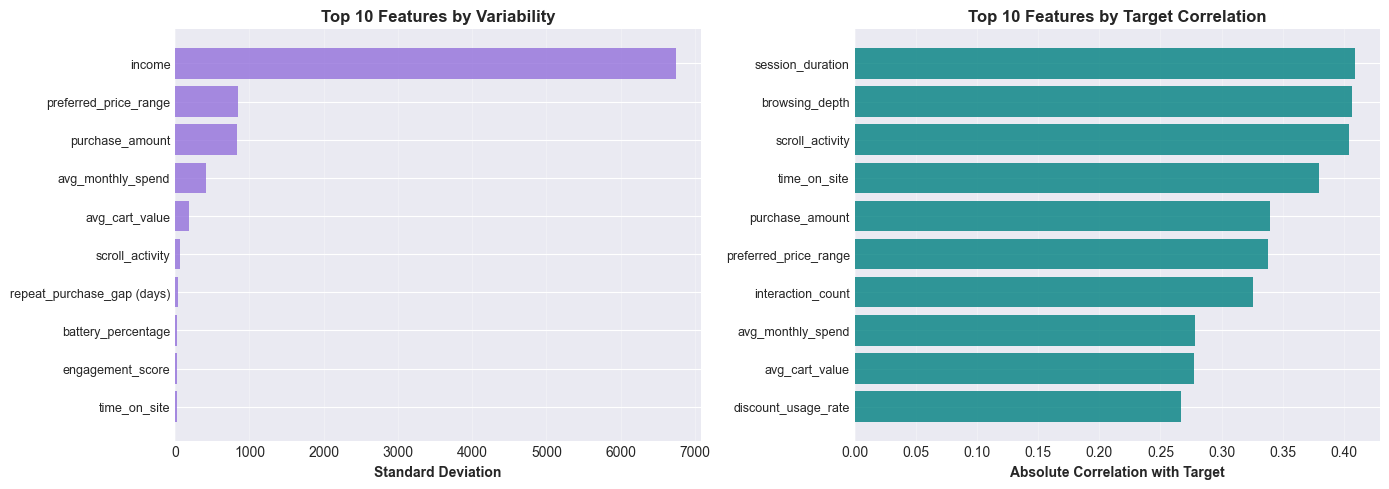


Total numeric features: 28

Top correlated features with target:
  • session_duration: 0.4091
  • browsing_depth: 0.4063
  • scroll_activity: 0.4038
  • time_on_site: 0.3795
  • purchase_amount: 0.3400
  • preferred_price_range: 0.3382
  • interaction_count: 0.3256
  • avg_monthly_spend: 0.2783
  • avg_cart_value: 0.2774
  • discount_usage_rate: 0.2670


In [26]:
# Additional Feature Analysis: Correlation and Variability
print(f"\n{'='*70}")
print("FEATURE STATISTICS & CORRELATION ANALYSIS")
print(f"{'='*70}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature variability analysis
numeric_feats = train_users_clean.select_dtypes(include=[np.number]).columns
if len(numeric_feats) > 0:
    feature_stats = train_users_clean[numeric_feats].describe().T
    top_features = feature_stats.nlargest(min(10, len(feature_stats)), 'std')
    
    axes[0].barh(range(len(top_features)), top_features['std'].values, color='mediumpurple', alpha=0.8)
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features.index, fontsize=9)
    axes[0].set_xlabel('Standard Deviation', fontweight='bold')
    axes[0].set_title(f'Top {len(top_features)} Features by Variability', fontweight='bold', fontsize=12)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Correlation with target
    numeric_train = train_users_clean[numeric_feats].copy()
    numeric_train['label_encoded'] = y_encoded
    correlations = numeric_train.corr()['label_encoded'].drop('label_encoded').abs().sort_values(ascending=False)
    top_corr = correlations.head(min(10, len(correlations)))
    
    axes[1].barh(range(len(top_corr)), top_corr.values, color='teal', alpha=0.8)
    axes[1].set_yticks(range(len(top_corr)))
    axes[1].set_yticklabels(top_corr.index, fontsize=9)
    axes[1].set_xlabel('Absolute Correlation with Target', fontweight='bold')
    axes[1].set_title(f'Top {len(top_corr)} Features by Target Correlation', fontweight='bold', fontsize=12)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal numeric features: {len(numeric_feats)}")
    print(f"\nTop correlated features with target:")
    for feat, corr in top_corr.items():
        print(f"  • {feat}: {corr:.4f}")
else:
    print("No numeric features found for analysis")
    
print(f"{'='*70}")

## 5.3 Contextual Bandit Algorithms

### Arm Mapping

According to the assignment, the arm index `j` maps to (News Category, User Context) combinations:

| Arm Index (j) | News Category | User Context |
|---------------|---------------|--------------|
| 0–3           | Entertainment, Education, Tech, Crime | User1 |
| 4–7           | Entertainment, Education, Tech, Crime | User2 |
| 8–11          | Entertainment, Education, Tech, Crime | User3 |

### Bandit Algorithm Implementations

### Simulation & Evaluation

Run RL simulation for T=10,000 steps and compare different hyperparameters.

### Experiment 1: Epsilon-Greedy

Test multiple values of ε and compare performance.

### Experiment 2: Upper Confidence Bound (UCB)

Test multiple values of exploration parameter C.

### Experiment 3: SoftMax

Use fixed temperature parameter τ = 1.

## 5.4 Recommendation Engine

Build an end-to-end recommendation system that:
1. Takes user features as input
2. Predicts user context (User1/User2/User3)
3. Selects optimal news category using trained bandit
4. Samples a specific article from that category

### Test Recommendation Engine

---
## Submission Checklist

- [ ] Roll number updated in first cell
- [ ] All cells executed without errors
- [ ] Classification report shows reasonable accuracy
- [ ] All three bandit algorithms implemented correctly
- [ ] Plots have labeled axes, legends, and titles
- [ ] Recommendation engine tested on test users
- [ ] README.md updated with analysis and insights
- [ ] Code pushed to branch: `firstname_U20230xxx`
- [ ] Notebook filename: `lab3_results_<roll_number>.ipynb`

---
**End of Notebook**